In [1]:
import pandas as pd
df = pd.read_parquet('catB_train.parquet')
print(f'There are {df.shape[0]} observations and {df.shape[1]} features in this dataset.', '\n')

There are 17992 observations and 304 features in this dataset. 



In [2]:
# Target Column
df["f_purchase_lh"] = df["f_purchase_lh"].fillna(0)

Exploratory Data Analysis

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Visualising Age versus conversion rate
df = df[df['cltdob_fix']!='None']
df['cltdob_fix'] = pd.to_datetime(df.iloc[:, 6], format ='mixed')
df['age'] = 2024-df['cltdob_fix'].dt.year

age = X = pd.concat([df['age'], df["f_purchase_lh"] ], axis=1)
age['age_bin'] = pd.cut(age['age'], np.linspace(0,100,21))
age.groupby('age_bin')['f_purchase_lh'].value_counts().unstack().plot(kind='bar', stacked=True)

In [39]:
# Find Numerical variables 
numeric_cols = X.select_dtypes(include=["int32", "int64", "float64"]).columns
X_numeric = X[numeric_cols]
print(f'There are {len(numeric_cols)} numerical features.', '\n')

There are 94 numerical features. 



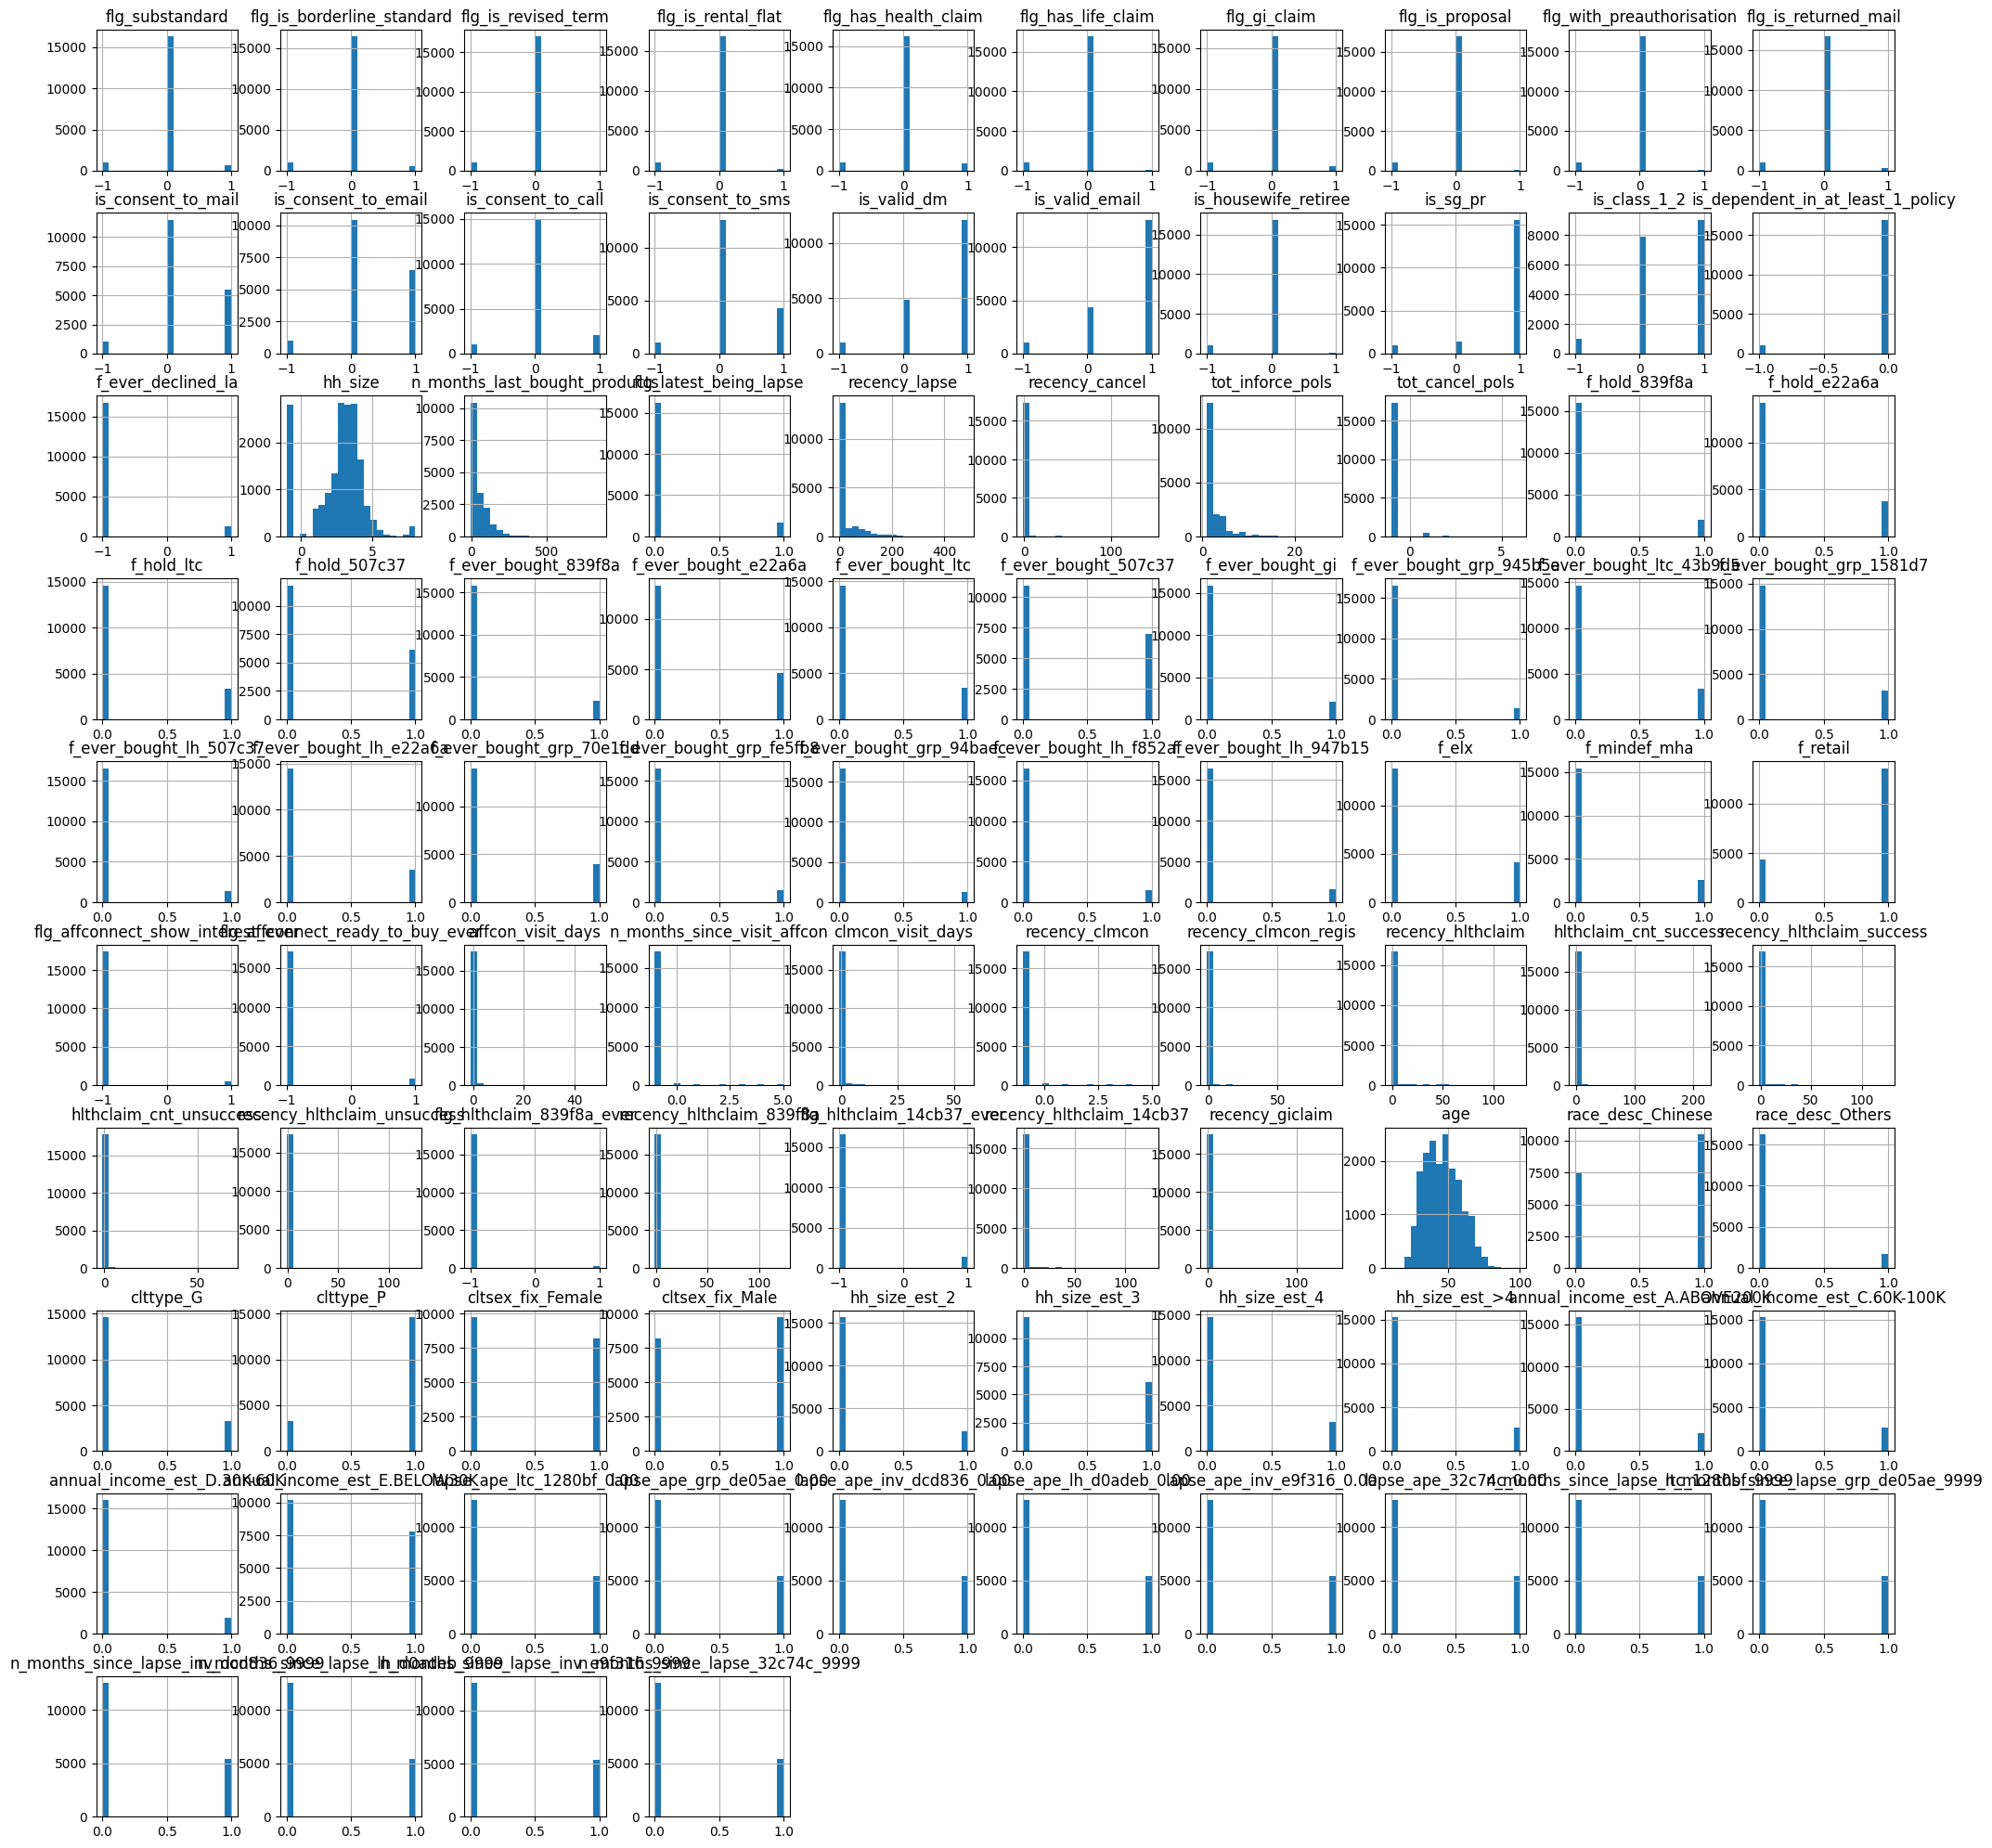

In [37]:
# To find the distributions and outlier in the each numerical variable
X_numeric.hist(figsize=(25,25),bins=20)
plt.show()

Pre-processing

In [46]:
from collections import Counter

y = df["f_purchase_lh"]
X = df.drop(columns=['f_purchase_lh'])

print(f'There are {Counter(y)[1]} zeroes in the target columns, constituting {round(Counter(y)[1]/len(y)*100, 2)} % of the all observations.', '\n')


SyntaxError: EOL while scanning string literal (2156109792.py, line 8)

In [12]:
# Replace missing vlaues in numeric columns with -1
X_numeric = X_numeric.apply(lambda x: x.fillna(-1))

# One-hot encoding for potencially categorical data 
non_numeric_cols = X.select_dtypes(include=["string", "object"]).columns
non_numeric_keep = []
for col in non_numeric_cols:
    if X[col].nunique() <= 10:
        if X[col].nunique() > 1: # Discard variables with zero variance
            non_numeric_keep.append(col)
X_non_numeric = pd.get_dummies(X[non_numeric_keep], dtype=float)

X = pd.concat([X_numeric, X_non_numeric], axis=1)

# Discard variables with low variance
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(0.05))
sel.fit(X)
X = X[X.columns.values[sel.get_support()]]

C:\Users\65835\AppData\Local\Temp\ipykernel_1204\1075801011.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cltdob_fix'] = pd.to_datetime(df.iloc[:, 6], format ='mixed')
C:\Users\65835\AppData\Local\Temp\ipykernel_1204\1075801011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = 2024-df['cltdob_fix'].dt.year
C:\Users\65835\AppData\Local\Temp\ipykernel_1204\1075801011.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [13]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Balancing Data by generating random samples of the minority group (y=1)
ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

# Balancing Data by generating synthetic data in the training group
smote = SMOTE(random_state=10)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

In [21]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=15, random_state=15, class_weight='balanced')

param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='f1', cv=3)
grid_search_rf.fit(X_smtom, y_smtom)

# The best-performing hyperparameters from grid search 
best_params_rf = grid_search_rf.best_params_

# Predict y values of testing group 
y_val_pred_rf = grid_search_rf.best_estimator_.predict(X_val)

CPU times: total: 42.1 s
Wall time: 43.4 s


Evaluate Model using Testing Group

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,precision_score, recall_score

accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
conf_matrix_rf = confusion_matrix(y_val, y_val_pred_rf)
f1_rf = f1_score(y_val, y_val_pred_rf)
precision_rf = precision_score(y_val, y_val_pred_rf)
recall_rf = recall_score(y_val, y_val_pred_rf)

print("\nRandom Forest Results:")
print(f"Best Hyperparameters: {best_params_rf}")
print(f"Accuracy: {accuracy_rf}")
print("Confusion Matrix:")
print(conf_matrix_rf)
print(f"F1 Score: {f1_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")


Random Forest Results:
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Accuracy: 0.9585420144685587
Confusion Matrix:
[[3425   23]
 [ 126   20]]
F1 Score: 0.21164021164021163
Precision: 0.46511627906976744
Recall: 0.136986301369863


In [23]:
def testing_hidden_data(test_data):
    test_data = test_data[test_data['cltdob_fix']!='None']
    test_data['cltdob_fix'] = pd.to_datetime(test_data.iloc[:, 6], format ='mixed')
    test_data['age'] = 2024-test_data['cltdob_fix'].dt.year

    test_data[numeric_cols] = test_data[numeric_cols].apply(lambda x: x.fillna(-1))
    test_data[non_numeric_keep] = pd.get_dummies(test_data[non_numeric_keep], dtype=float)

    prediction = grid_search_rf.best_estimator_.predict(test_data)
    return prediction